## Classifying Copyists of Manuscripts using K Nearest Neighbors and Decision Tree Classifier

Abhin Vijay


#### Introduction

: The Avila dataset contains data extracted from 800 images of the Avila Bible [1]. There are 10
features and each set of features corresponds to four consecutive rows of the manuscript There are 12
copyists for the manuscripts in the Class column. We will design classifier models to identify the copyists
of the manuscripts based on its features. This will indicate whether the features represented in the dataset
are reliably distinct between copyists so that the model can use them to identify the copyists. The features
will be analyzed to study their distributions and possible correlations between them. We will also tune the
hyperparameters of the models to see which set of parameters perform the best. We will shuffle through
different sets of features to identify the set of features that most effectively helps us identify the copyists.

In [1]:
#importing the neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#defining the column names
col_names=["intercolumnar distance","upper margin","lower margin","exploitation","row number","modular ratio",
           "interlinear spacing","weight","peak number", "modular ratio/ interlinear spacing","Class"]

In [3]:
#loading the training data
train_df=pd.read_csv("avila/avila-tr.txt",delimiter=',',header=None)

In [4]:
train_df.columns=col_names

In [5]:
#reading the testing data
test_df=pd.read_csv("avila/avila-ts.txt",delimiter=',',header=None)

In [6]:
test_df.columns=col_names

In [7]:
train_df.head()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


In [8]:
test_df.head()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
0,-3.498799,0.250492,0.232070,1.224178,-4.922215,1.145386,0.182426,-0.165983,-0.123005,1.087144,W
1,0.204355,-0.354049,0.320980,0.410166,-0.989576,-2.218127,0.220177,0.181844,2.090879,-2.009758,A
2,0.759828,-1.304042,-0.023991,-0.973663,-0.006417,-0.349509,-0.421580,-0.450127,0.469443,0.060952,I
3,-0.005490,0.360409,0.281860,-0.213479,-1.168333,-1.013906,-0.346080,1.176165,0.968347,-0.627999,E
4,0.080916,0.101320,0.104040,0.140490,0.261718,0.480988,0.710932,-0.253430,-0.497183,0.155681,A


#### Data Pre-Processing

In [9]:
#retrieving information about the dataset and its columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   intercolumnar distance              10430 non-null  float64
 1   upper margin                        10430 non-null  float64
 2   lower margin                        10430 non-null  float64
 3   exploitation                        10430 non-null  float64
 4   row number                          10430 non-null  float64
 5   modular ratio                       10430 non-null  float64
 6   interlinear spacing                 10430 non-null  float64
 7   weight                              10430 non-null  float64
 8   peak number                         10430 non-null  float64
 9   modular ratio/ interlinear spacing  10430 non-null  float64
 10  Class                               10430 non-null  object 
dtypes: float64(10), object(1)
memory usage: 8

In [10]:
#checking for null values
train_df.isnull().sum()

intercolumnar distance                0
upper margin                          0
lower margin                          0
exploitation                          0
row number                            0
modular ratio                         0
interlinear spacing                   0
weight                                0
peak number                           0
modular ratio/ interlinear spacing    0
Class                                 0
dtype: int64

In [11]:
#checking for value counts of different classes
train_df["Class"].value_counts()

A    4286
F    1961
E    1095
I     831
X     522
H     519
G     446
D     352
Y     266
C     103
W      44
B       5
Name: Class, dtype: int64

In [12]:
#checking the value counts of different intercolumnar distance
train_df["intercolumnar distance"].value_counts()

-3.498799    308
 0.154980    286
 0.080916    272
 0.130292    271
 0.117948    265
            ... 
-2.449572      5
-3.412392      5
-3.486455      4
-2.474260      4
 0.000000      1
Name: intercolumnar distance, Length: 144, dtype: int64

In [13]:
train_df.shape

(10430, 11)

### Data Explorations

As we can see there are 10430 rows and 11 columns including the target ‘Class’. All the columns are of float data type as required except the Class column which contains categorical value.  The class categories of the dataset  and their value counts are shown in fig 2. Our first step is to analyze the distribution of the features. Distplot from Seaborn library was used to plot the boxplots of all the features. From the distributions represented in the graph (fig 3), it is clear that some of the features have outliers

In [14]:
#examining the descriptive statistics of the dataset
train_df.describe()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing
count,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000
mean,0.000852,0.033611,-0.000525,-0.002387,0.006370,0.013973,0.005605,0.010323,0.012914,0.000818
std,0.991431,3.920868,1.120202,1.008527,0.992053,1.126245,1.313754,1.003507,1.087665,1.007094
min,-3.498799,-2.426761,-3.210528,-5.440122,-4.922215,-7.450257,-11.935457,-4.247781,-5.486218,-6.719324
25%,-0.128929,-0.259834,0.064919,-0.528002,0.172340,-0.598658,-0.044076,-0.541991,-0.372457,-0.516097
50%,0.043885,-0.055704,0.217845,0.095763,0.261718,-0.058835,0.220177,0.111803,0.064084,-0.034513
75%,0.204355,0.203385,0.352988,0.658210,0.261718,0.564038,0.446679,0.654944,0.500624,0.530855
max,11.819916,386.000000,50.000000,3.987152,1.066121,53.000000,83.000000,13.173081,44.000000,4.671232


#### Outlier Detection and Distribution Analysis

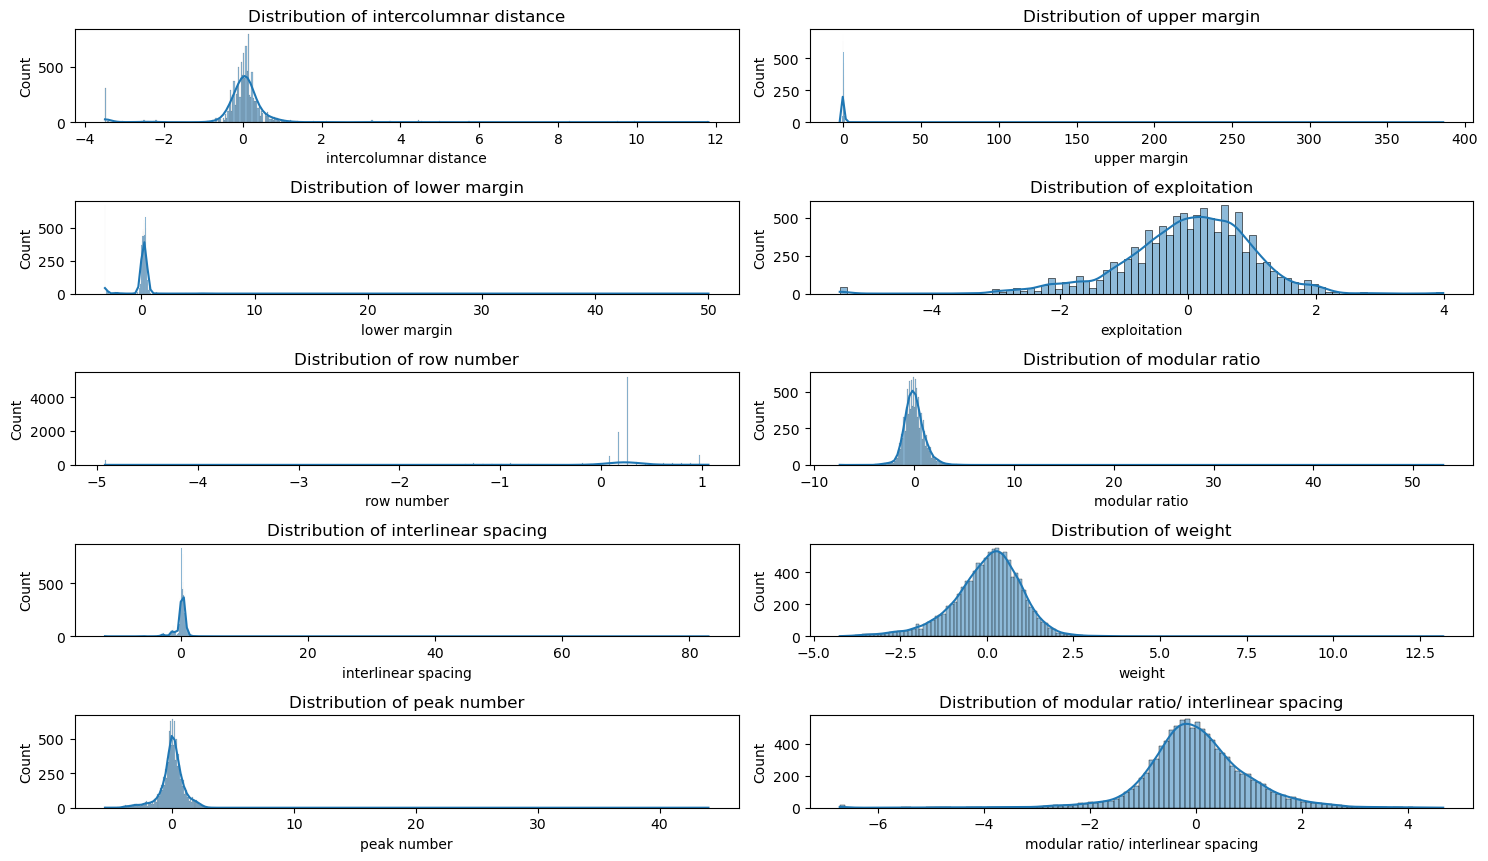

In [15]:
num_cols = len(train_df.columns) #number of columns in the dataframe
nrows = (num_cols + 1) // 2 # number of rows for the subplots
n_cols = 2 #number of columns for the subplots
# Creating subplots for plotting each column distribution
fig, axes = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(15, 10))
# # Flattening the axes array 
axes = axes.flatten()
# iterating through each column and plotting the distribution
for i, col in enumerate(train_df.columns[:-1]):
    sns.histplot(train_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
# Removing plots that are empty
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
# Adjust layout
plt.tight_layout()
plt.savefig('distplot_all_features.jpg', format='jpg')
plt.show()

On inspecting the columns 4 at a time, we get a close look at the nature of their distributions. For instance, the majority of the distribution for upper margin is less than zero, but the graph’s x axis shows values up to 400 which means there is a high value in hundreds hiding in there. The same logic can be applied to other columns to identify the outliers. When the values above 10 were inspected for each of these suspected columns, the suspicions were proven valid. The row number 6619 of the dataset contained most of the outliers. It had an impossible high value of 386 for upper margin, 53 for modular ratio, 83 for interlinear spacing and 44 for peak number. This row was removed from train_df. The other row that had the outlier was 9402 which had an upper margin value of 43.13; This row was removed as well.


<Axes: xlabel='exploitation', ylabel='Count'>

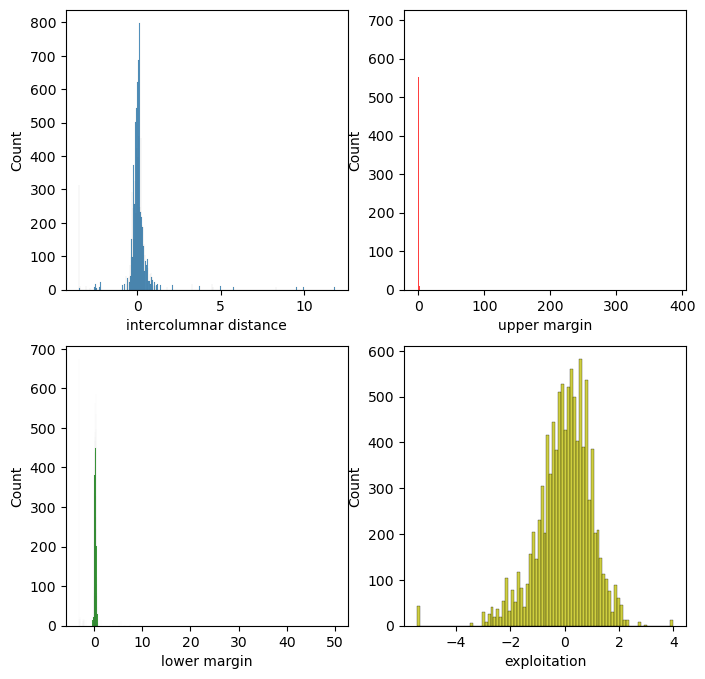

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(train_df["intercolumnar distance"], ax=axes[0, 0])
sns.histplot(train_df['upper margin'], ax=axes[0, 1], color='r')
sns.histplot(train_df['lower margin'], ax=axes[1, 0], color='g')
sns.histplot(train_df['exploitation'], ax=axes[1, 1], color='y')

<Axes: xlabel='interlinear spacing', ylabel='Count'>

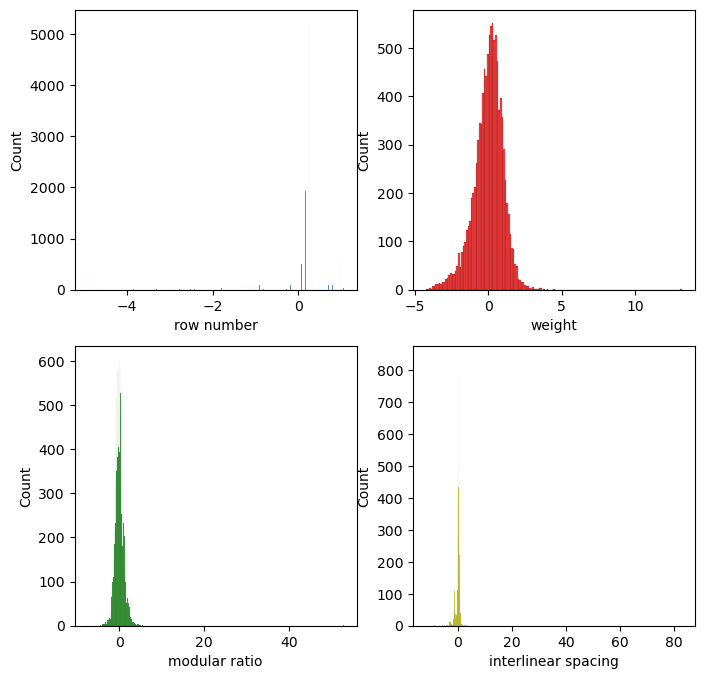

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(train_df["row number"], ax=axes[0, 0])
sns.histplot(train_df['weight'], ax=axes[0, 1], color='r')
sns.histplot(train_df['modular ratio'], ax=axes[1, 0], color='g')
sns.histplot(train_df['interlinear spacing'], ax=axes[1, 1], color='y')

In [18]:
train_df.loc[train_df["intercolumnar distance"]>10]["intercolumnar distance"]

1289    11.819916
1390    11.819916
1447    11.819916
1886    11.819916
2199    11.819916
4507    11.819916
6235    11.819916
7153    11.819916
Name: intercolumnar distance, dtype: float64

In [19]:
train_df.loc[train_df["lower margin"]>10]["lower margin"]

6619    50.0
Name: lower margin, dtype: float64

In [20]:
#retrieving column with the outlier value
train_df.loc[train_df["lower margin"]==50]

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
6619,0.0,386.0,50.0,0.168104,0.0,53.0,83.0,0.275032,44.0,0.63802,A


In [21]:
#locating values where upper margin is greater than 10
train_df.loc[train_df["upper margin"]>10]["upper margin"]

207       10.653310
256       16.965662
274       17.570202
372       16.965662
420       17.570202
691       10.653310
708       12.655362
2014      12.655362
2113      13.895848
2351      13.895848
2905      12.655362
3718      10.653310
4245      19.470188
4529      17.570202
4639      12.655362
5662      10.653310
6619     386.000000
6946      19.470188
7119      12.655362
7176      19.470188
7443      10.653310
7740      12.655362
7777      12.655362
8686      13.895848
9402      43.133656
9457      12.655362
9794      17.570202
10021     10.653310
Name: upper margin, dtype: float64

In [22]:
#retrieving column with the outlier value
train_df.loc[train_df["upper margin"]==386.00]

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
6619,0.0,386.0,50.0,0.168104,0.0,53.0,83.0,0.275032,44.0,0.63802,A


In [23]:
#retrieving column with the outlier value
train_df.loc[train_df["upper margin"]==43.133656]

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
9402,-3.498799,43.133656,-3.210528,-5.440122,-4.832837,-7.450257,-11.935457,13.173081,-5.486218,-6.719324,A


In [24]:
#Dropping the rows with outliers
train_df.drop([6619,9402],inplace=True)

In [25]:
train_df.loc[train_df["exploitation"]>10]["exploitation"]

Series([], Name: exploitation, dtype: float64)

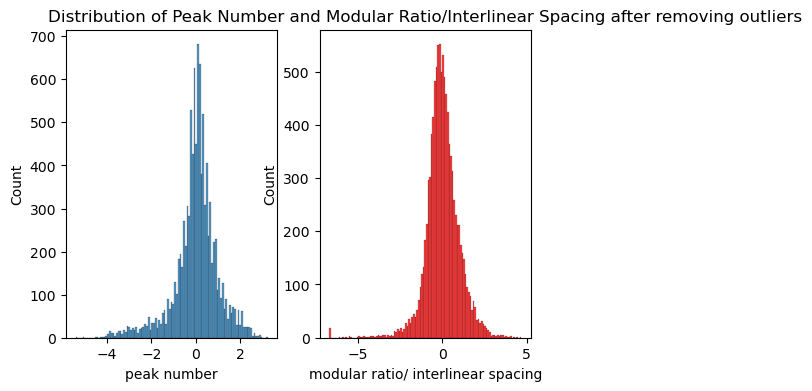

In [26]:
#plotting the distribution after removing the outliers
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
sns.histplot(train_df['peak number'], ax=axes[0])
sns.histplot(train_df['modular ratio/ interlinear spacing'], ax=axes[1], color='r')
plt.title("Distribution of Peak Number and Modular Ratio/Interlinear Spacing after removing outliers")
plt.savefig("peak_iner_by_mod.jpg",format="jpg")

In [27]:
#looking for outliers in the peak number column
train_df.loc[train_df["peak number"]>10]["peak number"]

Series([], Name: peak number, dtype: float64)

In [28]:
#retrieving the column with the outlier
train_df.loc[train_df["peak number"]==44.0]

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class


In [29]:
#examining the raow number column
train_df['row number'].value_counts()

 0.261718    5210
 0.172340    1920
 0.976743     565
 0.082961     500
-4.922215     265
 0.351096     167
-0.006417     131
 0.887365     116
-1.078955     112
-1.257711     112
-1.168333     111
 0.619230     102
-0.185173      98
-0.900198      94
 0.708609      92
-0.095795      91
 0.797987      88
-1.347089      85
-0.989576      79
 0.440474      54
-0.721442      53
 1.066121      41
 0.529852      35
-1.793980      25
-0.542686      25
-1.436467      20
-2.687761      19
-3.045274      19
-0.274551      17
-3.224030      13
-2.419627      13
-0.632064      13
-2.777139      13
-0.363929      12
-1.525845      11
-0.810820      11
-2.509005      11
-1.615223      11
-1.704602      11
-2.062114      11
-3.313408      10
-4.654081       9
-4.832837       9
-3.134652       8
-0.453307       6
-3.849677       6
-4.743459       4
Name: row number, dtype: int64

In [30]:
train_df.loc[train_df['interlinear spacing']>10]['interlinear spacing']

4584    10.714792
Name: interlinear spacing, dtype: float64

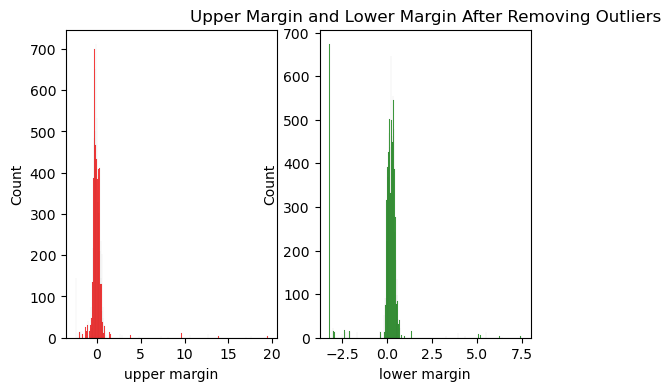

In [31]:
#plotting the distribution after removing outliers
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
sns.histplot(train_df['upper margin'],ax=axes[0],color='r')
sns.histplot(train_df['lower margin'], color='g',ax=axes[1])
plt.title("Upper Margin and Lower Margin After Removing Outliers")
plt.savefig("up_low_out.jpg",format="jpg")

Text(0.5, 1.0, 'Boxplot showing the distribution of features')

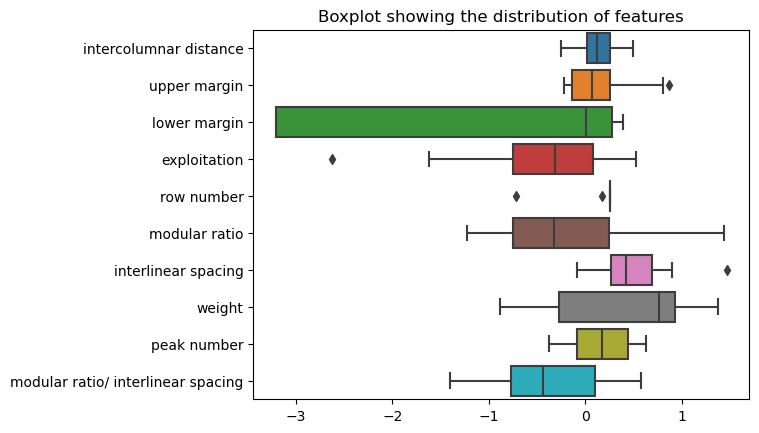

In [32]:
#plotting boxplots of each columns to detect outliers 
sns.boxplot(train_df[:10],orient="h")
plt.title("Boxplot showing the distribution of features")

#### Correlation between Variables

In order to study the correlation between variables, a heatmap plot was plotted. 

C:\Users\abhin\AppData\Local\Temp\ipykernel_16444\1338787606.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr())


Text(0.5, 1.0, 'Heatmap representing correlations between variables')

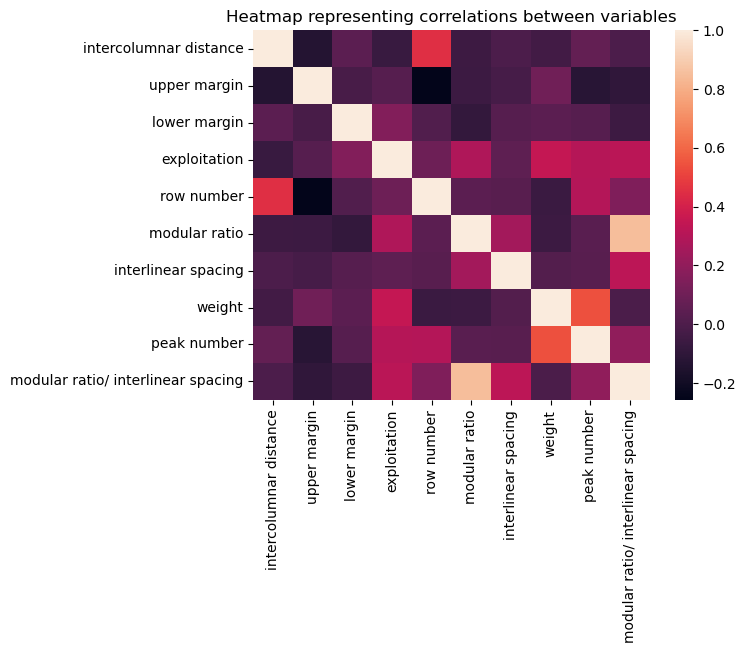

In [33]:
sns.heatmap(train_df.corr())
plt.title("Heatmap representing correlations between variables")


In [34]:
train_df.corr()

C:\Users\abhin\AppData\Local\Temp\ipykernel_16444\1233823885.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.corr()


,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing
intercolumnar distance,1.000000,-0.139255,0.037296,-0.067297,0.451099,-0.053017,-0.005438,-0.039244,0.062989,-0.005112
upper margin,-0.139255,1.000000,-0.017172,0.025194,-0.257509,-0.059193,-0.022776,0.103237,-0.122986,-0.097841
lower margin,0.037296,-0.017172,1.000000,0.157516,0.011160,-0.088556,0.023183,0.041995,0.022691,-0.055662
exploitation,-0.067297,0.025194,0.157516,1.000000,0.094142,0.286715,0.048997,0.349125,0.303587,0.321596
row number,0.451099,-0.257509,0.011160,0.094142,1.000000,0.041570,0.028519,-0.065703,0.297584,0.148960
modular ratio,-0.053017,-0.059193,-0.088556,0.286715,0.041570,1.000000,0.249049,-0.059791,0.035167,0.847873
interlinear spacing,-0.005438,-0.022776,0.023183,0.048997,0.028519,0.249049,1.000000,0.015851,0.032216,0.325273
weight,-0.039244,0.103237,0.041995,0.349125,-0.065703,-0.059791,0.015851,1.000000,0.542034,-0.007749
peak number,0.062989,-0.122986,0.022691,0.303587,0.297584,0.035167,0.032216,0.542034,1.000000,0.197327
modular ratio/ interlinear spacing,-0.005112,-0.097841,-0.055662,0.321596,0.148960,0.847873,0.325273,-0.007749,0.197327,1.000000


Text(0.5, 1.0, 'Scatter Plot of Modular/RatioInterlinear Spacing vs Modular Ratio')

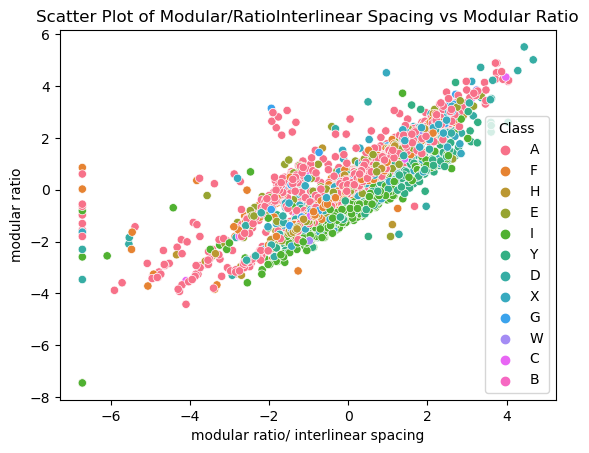

In [35]:
#plotting scatter between variables with high correlation
sns.scatterplot(x="modular ratio/ interlinear spacing",y="modular ratio",data=train_df,hue="Class")
plt.title("Scatter Plot of Modular/RatioInterlinear Spacing vs Modular Ratio")

As suspected there is indeed a correlation. This could be because modular ratio is the numerator of  modular ration/interlinear spacing which is a ratio. It would be interesting to observe if having both of these features is redundant while training the model. We can confirm this during feature selection. Since we set the hue of the scatter plot as the classes we can notice some interesting patterns here. It looks like the class A values have a higher modular ratio than the other classes. And class ‘I’ has a lower modular ratio than the others. 

Text(0.5, 1.0, 'Scatter Plot of Peak Number vs Weight')

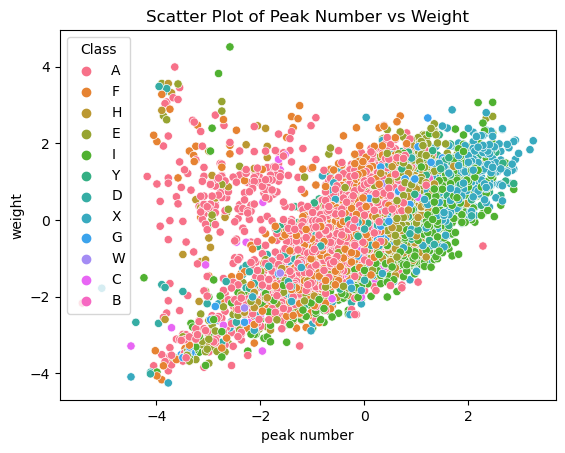

In [37]:
#the correaltion between these are not high enough
sns.scatterplot(x='peak number',y='weight',data=train_df,hue="Class")
plt.title("Scatter Plot of Peak Number vs Weight")

Text(0.5, 1.0, 'Scatter Plot of Interlinear Spacing vs Row Number')

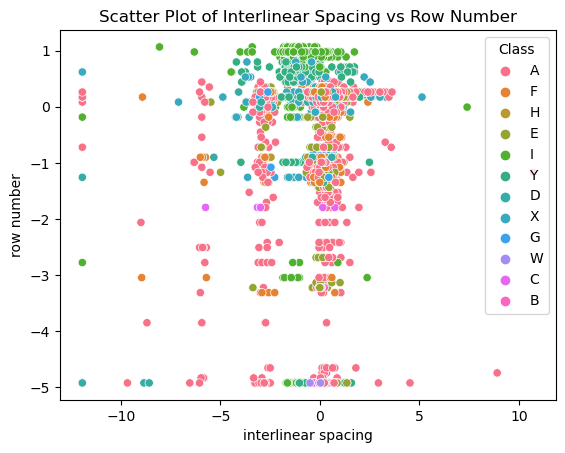

In [38]:
sns.scatterplot(x='interlinear spacing',y='row number',data=train_df,hue="Class")
plt.title("Scatter Plot of Interlinear Spacing vs Row Number")

### Data Modelling

##### Encoding Target Variables


The first classifier we will use to model the data is K Nearest Neighbors. Since KNN models can’t be directly trained and tested on categorical data, we will substitute the classes of train and test data with integer values.  After splitting the training and testing data into X and y variables, a basic KNN classifier was fitted with n_neighbors=5. 

In [39]:
#ensuring we have allthe target classes in both the datasets
set(train_df["Class"].unique())==set(test_df["Class"].unique())

True

In [40]:
map_dict = {'A': 1,"B":2, 'F': 3, 'H': 4,'E':5,"I":6,"Y":7,"D":8,"X":9,"G":10,"C":11,"W":12}

In [41]:
#replacing categorical values of classes with integer values
train_df["Class"].replace(map_dict,inplace=True)
test_df["Class"].replace(map_dict,inplace=True)

In [42]:
train_df['Class'].value_counts()

1     4284
3     1961
5     1095
6      831
9      522
4      519
10     446
8      352
7      266
11     103
12      44
2        5
Name: Class, dtype: int64

In [43]:
# Separating the training and testing datasets into X and y
X_train=train_df.iloc[:,:-1]
y_train=train_df.iloc[:,10]
X_test=test_df.iloc[:,:-1]
y_test=test_df.iloc[:,10]

#### K Nearest Neighbors Classifier

In [44]:
from sklearn.neighbors import KNeighborsClassifier #loading the K Nearest Neighbor package from sklearn library
knn_clf = KNeighborsClassifier(5) #initialising the classfier object
fitted_class =knn_clf.fit(X_train, y_train) #fitting the training data to the classifier

In [45]:
y_pred = fitted_class.predict(X_test) #predicting the classes for test data

In [46]:
y_pred

array([12,  1,  1, ...,  1,  1,  1], dtype=int64)

In [47]:
from sklearn.metrics import confusion_matrix #importing confusion matrix package from sklearn.metrics library
cm = confusion_matrix(y_test, y_pred) #passing the test set target values and the predicted values into the confusion matrix

In [48]:
cm #confusion matrix

array([[3693,    0,  461,   31,   45,    3,    3,   12,    2,   36,    0,
           0],
       [   0,    5,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [ 611,    0, 1285,   18,   11,    2,    2,    3,    0,   30,    0,
           0],
       [ 145,    0,   43,  286,   31,    0,    0,    3,    2,    8,    2,
           0],
       [ 216,    0,  112,   61,  663,    3,    2,   11,   12,   10,    5,
           0],
       [  30,    0,    9,    2,    3,  777,    8,    1,    2,    0,    0,
           0],
       [  25,    0,    3,    0,    7,   21,  201,    0,   10,    0,    0,
           0],
       [  85,    0,   59,   10,   37,    1,    0,  160,    0,    1,    0,
           0],
       [  34,    0,    3,    5,   19,    3,   28,    0,  429,    1,    0,
           0],
       [ 122,    0,   59,   13,   20,    0,    0,    0,    2,  231,    0,
           0],
       [  34,    0,   17,    5,   15,    1,    0,    3,    0,    0,   28,
           0],
       [  20,    0,  

In [49]:
from sklearn.metrics import classification_report #importing classfication report from sklearn.metrics library
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.74      0.86      0.79      4286
           2       1.00      1.00      1.00         5
           3       0.63      0.65      0.64      1962
           4       0.66      0.55      0.60       520
           5       0.78      0.61      0.68      1095
           6       0.96      0.93      0.95       832
           7       0.82      0.75      0.79       267
           8       0.83      0.45      0.59       353
           9       0.93      0.82      0.87       522
          10       0.73      0.52      0.60       447
          11       0.80      0.27      0.41       103
          12       1.00      0.44      0.62        45

    accuracy                           0.75     10437
   macro avg       0.82      0.66      0.71     10437
weighted avg       0.75      0.75      0.74     10437



#### Parameter Tuning

These results are not terrible but they still need some work. For the default n_neighbor value of 5, we were able to obtain a weighted average score of 75% precision and recall.  Let’s try to find the best possible value for neighbors. For this , I iterated through a range of values and plotted their performance on a line graph.


In [50]:
from sklearn.metrics import accuracy_score
n=list(range(1,30))
acc_score_dict={}
for i in range(1,30):
    knn_clf = KNeighborsClassifier(i)
    fitted_class = knn_clf.fit(X_train, y_train) #fitting the training data to the classifier
    y_pred = fitted_class.predict(X_test)
    score=accuracy_score(y_test,y_pred)
    acc_score_dict[i]=score

In [51]:
acc_score_dict

{1: 0.7578806170355467,
 2: 0.7388138353933122,
 3: 0.7562517964932451,
 4: 0.7459998083740539,
 5: 0.7452333045894414,
 6: 0.7339273737664079,
 7: 0.7349813164702501,
 8: 0.7266455878125898,
 9: 0.7243460764587525,
 10: 0.7205135575356904,
 11: 0.7176391683433937,
 12: 0.711123886174188,
 13: 0.7088243748203507,
 14: 0.7040337261665229,
 15: 0.7027881575165278,
 16: 0.6973268180511641,
 17: 0.6957938104819392,
 18: 0.691769665612724,
 19: 0.6924403564242598,
 20: 0.6894701542588867,
 21: 0.6871706429050494,
 22: 0.6842962537127527,
 23: 0.6825716201973747,
 24: 0.6797930439781547,
 25: 0.6774935326243173,
 26: 0.674331704512791,
 27: 0.6728945099166427,
 28: 0.6711698764012647,
 29: 0.6693494299128102}

Text(0.5, 1.0, 'KNNN Classifier Accuracy for Different n Values')

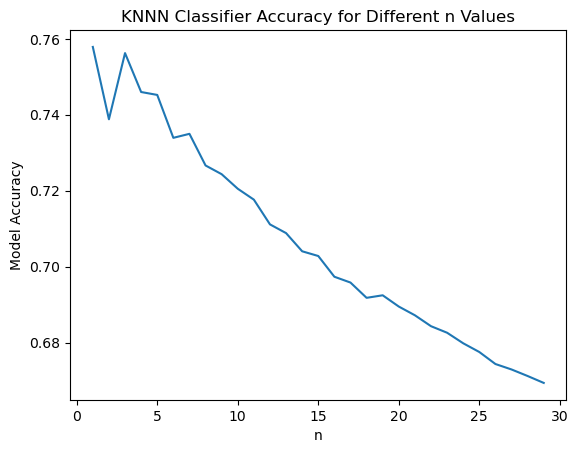

In [52]:
#plotting KNN accuracy for different n values
plt.plot(n,acc_score_dict.values())
plt.xlabel("n")
plt.ylabel("Model Accuracy")
plt.title("KNNN Classifier Accuracy for Different n Values")

In [53]:
knn_clf = KNeighborsClassifier(1) #initialising the classfier object with n=1
fitted_class =knn_clf.fit(X_train, y_train) #fitting the training data to the classifier

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.64      0.89      0.74      4286
           2       0.00      0.00      0.00         5
           3       0.58      0.53      0.55      1962
           4       0.60      0.42      0.49       520
           5       0.71      0.45      0.55      1095
           6       0.93      0.85      0.89       832
           7       0.83      0.61      0.70       267
           8       0.74      0.16      0.27       353
           9       0.92      0.66      0.77       522
          10       0.69      0.37      0.48       447
          11       0.00      0.00      0.00       103
          12       0.00      0.00      0.00        45

    accuracy                           0.67     10437
   macro avg       0.55      0.41      0.45     10437
weighted avg       0.67      0.67      0.65     10437



C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
knn_clf = KNeighborsClassifier(3) #initialising the classfier object with n=3
fitted_class =knn_clf.fit(X_train, y_train) #fitting the training data to the classifier

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.64      0.89      0.74      4286
           2       0.00      0.00      0.00         5
           3       0.58      0.53      0.55      1962
           4       0.60      0.42      0.49       520
           5       0.71      0.45      0.55      1095
           6       0.93      0.85      0.89       832
           7       0.83      0.61      0.70       267
           8       0.74      0.16      0.27       353
           9       0.92      0.66      0.77       522
          10       0.69      0.37      0.48       447
          11       0.00      0.00      0.00       103
          12       0.00      0.00      0.00        45

    accuracy                           0.67     10437
   macro avg       0.55      0.41      0.45     10437
weighted avg       0.67      0.67      0.65     10437



C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
knn_clf = KNeighborsClassifier(5, weights='distance') #initialising the classfier object
fitted_class = knn_clf.fit(X_train, y_train) #fitting the training data to the classifier
y_pred = fitted_class.predict(X_test)

In [58]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[3631,    0,  477,   43,   57,    2,    4,   17,    3,   52,    0,
           0],
       [   0,    5,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [ 534,    0, 1335,   22,   17,    2,    3,    5,    0,   44,    0,
           0],
       [ 113,    0,   48,  306,   34,    0,    0,    3,    2,   10,    4,
           0],
       [ 159,    0,   82,   47,  749,    1,    2,   17,   15,   16,    7,
           0],
       [  24,    0,    5,    2,    3,  787,    8,    1,    2,    0,    0,
           0],
       [  19,    0,    3,    0,    9,   17,  208,    0,   11,    0,    0,
           0],
       [  70,    0,   40,    8,   38,    1,    0,  192,    1,    1,    2,
           0],
       [  23,    0,    3,    4,   19,    2,   27,    0,  443,    1,    0,
           0],
       [ 101,    0,   58,   11,   19,    0,    0,    0,    1,  257,    0,
           0],
       [  28,    0,   18,    3,   14,    0,    0,    2,    0,    0,   38,
           0],
       [  12,    0,  

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.77      0.85      0.81      4286
           2       1.00      1.00      1.00         5
           3       0.64      0.68      0.66      1962
           4       0.69      0.59      0.63       520
           5       0.78      0.68      0.73      1095
           6       0.97      0.95      0.96       832
           7       0.83      0.78      0.80       267
           8       0.81      0.54      0.65       353
           9       0.92      0.85      0.88       522
          10       0.67      0.57      0.62       447
          11       0.75      0.37      0.49       103
          12       1.00      0.60      0.75        45

    accuracy                           0.76     10437
   macro avg       0.82      0.71      0.75     10437
weighted avg       0.77      0.76      0.76     10437



In [60]:
knn_clf = KNeighborsClassifier(5, weights='distance',p=1) #initialising the classfier object with p=1
fitted_class = knn_clf.fit(X_train, y_train) #fitting the training data to the classifier
y_pred = fitted_class.predict(X_test)

In [61]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[3848,    0,  325,   28,   33,    1,    1,    7,    1,   42,    0,
           0],
       [   0,    5,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [ 367,    0, 1547,   17,    8,    1,    1,    0,    0,   21,    0,
           0],
       [  71,    0,   32,  386,   21,    0,    0,    1,    0,    6,    3,
           0],
       [  94,    0,   72,   26,  867,    1,    1,   12,    8,   12,    2,
           0],
       [  16,    0,    3,    2,    1,  803,    2,    0,    1,    4,    0,
           0],
       [  15,    0,    3,    0,    7,    9,  223,    0,    9,    1,    0,
           0],
       [  44,    0,   26,    1,   25,    0,    0,  255,    0,    1,    1,
           0],
       [  18,    0,    2,    3,   10,    0,   23,    1,  465,    0,    0,
           0],
       [  73,    0,   47,    3,    9,    0,    0,    0,    1,  314,    0,
           0],
       [  24,    0,    8,    0,    9,    0,    0,    3,    0,    0,   59,
           0],
       [   2,    0,  

In [62]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.84      0.90      0.87      4286
           2       1.00      1.00      1.00         5
           3       0.75      0.79      0.77      1962
           4       0.83      0.74      0.78       520
           5       0.87      0.79      0.83      1095
           6       0.99      0.97      0.98       832
           7       0.89      0.84      0.86       267
           8       0.91      0.72      0.81       353
           9       0.96      0.89      0.92       522
          10       0.78      0.70      0.74       447
          11       0.91      0.57      0.70       103
          12       1.00      0.91      0.95        45

    accuracy                           0.84     10437
   macro avg       0.89      0.82      0.85     10437
weighted avg       0.85      0.84      0.84     10437



#### Feature Selection

 In order to select the ideal set of features, Hill Climbing Method was used. In this method we create a shuffled list of features. We start with one feature and validate the model using it. The accuracy of the model is current accuracy. Then we iterate through the list of features and select the next feature. We train and validate the model with this feature along with the previous one. If the current accuracy is higher than the previous one, the feature is kept or else removed. We repeat this until we obtain a set of features that give us optimum accuracy. After running this algorithm, we got a score of 98% with the features 2 (lower margin), 6 (interlinear spacing), 4 (row number), 0 (intercolumnar distance), 3 (exploitation), 1 (upper margin).



In [63]:
from sklearn.utils import shuffle #importing shuffle package from sklearn library
new_idx = [] # initialzing an empty list for the new column indices
current_Max = 0.0 #setting the current maximum score as 0
col_no = 10 #setting the number of columns
col_idx_rd = shuffle(range(0,col_no), random_state=1) #shuffling the columns number
for cur_f in range(0, col_no): #iterating as many times as the number of columns
    new_idx.append(col_idx_rd[cur_f]) # Adding the current column index into list of column indices
    newX_train = X_train.iloc[:, new_idx] #creating a new train set with columns of the new index list
    newX_test=X_test.iloc[:, new_idx]  #creating a new train set with columns of the new index list
    clf = KNeighborsClassifier(5, weights='distance', p=1) #initialising the classifier object
    fit = clf.fit(newX_train, y_train)  #fitting the classifier
    cur_Score = clf.score(newX_test, y_test)  #calculating the accuracy score with the current set of features
    if cur_Score < current_Max:  #if the current score is less than current maximum score, 
        new_idx.remove(col_idx_rd[cur_f]) #the indices of the features are removed from new index list
    else:
        current_Max= cur_Score #else current score is the maximum score
        print("Score with " + str(len(new_idx)) + " selected features: " + str(cur_Score))

Score with 1 selected features: 0.5388521605825429
Score with 2 selected features: 0.547858580051739
Score with 3 selected features: 0.6555523617897864
Score with 4 selected features: 0.8390342052313883
Score with 5 selected features: 0.9555427804924786
Score with 6 selected features: 0.9803583405193063


In [64]:
print(new_idx)

[2, 6, 4, 0, 3, 1]


In [65]:
X_train=X_train.iloc[:,[2, 6, 4, 0, 3, 1]]
X_test=X_test.iloc[:,[2, 6, 4, 0, 3, 1]]
knn_clf = KNeighborsClassifier(5, weights='distance',p=1) #initialising the classfier object with p=1
fitted_class = knn_clf.fit(X_train, y_train) #fitting the training data to the classifier
y_pred = fitted_class.predict(X_test)

In [66]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[4240,    2,   37,    5,    2,    0,    0,    0,    0,    0,    0,
           0],
       [   1,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [  49,    0, 1898,    7,    4,    0,    0,    1,    1,    2,    0,
           0],
       [   9,    0,    3,  506,    0,    0,    0,    0,    0,    0,    2,
           0],
       [   9,    0,    7,    0, 1073,    1,    0,    0,    4,    0,    1,
           0],
       [   6,    0,    0,    0,    0,  823,    0,    0,    3,    0,    0,
           0],
       [   2,    0,    0,    0,    3,    0,  260,    0,    2,    0,    0,
           0],
       [   4,    0,    0,    0,    0,    0,    0,  348,    1,    0,    0,
           0],
       [   3,    0,    1,    0,    2,    0,    5,    1,  510,    0,    0,
           0],
       [  15,    0,    0,    0,    0,    0,    0,    0,    0,  432,    0,
           0],
       [   4,    0,    0,    4,    2,    0,    0,    0,    0,    0,   93,
           0],
       [   0,    0,  

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.98      0.99      0.98      4286
           2       0.67      0.80      0.73         5
           3       0.98      0.97      0.97      1962
           4       0.97      0.97      0.97       520
           5       0.99      0.98      0.98      1095
           6       1.00      0.99      0.99       832
           7       0.98      0.97      0.98       267
           8       0.99      0.99      0.99       353
           9       0.98      0.98      0.98       522
          10       1.00      0.97      0.98       447
          11       0.97      0.90      0.93       103
          12       1.00      1.00      1.00        45

    accuracy                           0.98     10437
   macro avg       0.96      0.96      0.96     10437
weighted avg       0.98      0.98      0.98     10437



#### Decision Tree Classifier

The next model we will train is a Decision Tree Classifier.  It is a supervised learning model which is ideal for classification. We will first train the model with just the default parameters. The precision and recall scores obtained after training the basic model is very high compared to what we got with KNN with default parameters.


In [68]:
from sklearn.tree import DecisionTreeClassifier #importing the classifier package from tree library

In [69]:
X_train=train_df.iloc[:,:-1]
y_train=train_df.iloc[:,10]
X_test=test_df.iloc[:,:-1]
y_test=test_df.iloc[:,10]

In [70]:
dtree_clf=DecisionTreeClassifier() #initialising the classifier object
fit=dtree_clf.fit(X_train,y_train)
y_pred=fit.predict(X_test)

In [71]:
cm = confusion_matrix(y_test, y_pred) #passing the test set target values and the predicted values into the confusion matrix
cm

array([[4201,    0,   30,   24,   13,    7,    0,    4,    2,    2,    0,
           3],
       [   0,    4,    0,    0,    0,    0,    0,    0,    0,    1,    0,
           0],
       [  30,    0, 1912,    3,    4,    2,    0,    2,    0,    9,    0,
           0],
       [  11,    0,    0,  500,    2,    2,    0,    0,    0,    2,    3,
           0],
       [  13,    0,    2,    7, 1036,    1,    2,   17,   17,    0,    0,
           0],
       [  12,    0,    0,    0,    0,  819,    0,    0,    1,    0,    0,
           0],
       [   1,    0,    0,    0,    1,    0,  251,    0,   14,    0,    0,
           0],
       [   0,    0,    0,    0,   13,    0,    0,  340,    0,    0,    0,
           0],
       [   4,    0,    0,    1,   14,    1,    9,    1,  487,    1,    0,
           4],
       [   1,    0,   10,    3,    0,    0,    0,    0,    0,  433,    0,
           0],
       [   1,    0,    0,    0,    0,    0,    0,    1,    0,    0,  101,
           0],
       [   0,    0,  

In [72]:
print(classification_report(y_test,y_pred)) #printing the classificatio report for the decision tree classifier

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      4286
           2       1.00      0.80      0.89         5
           3       0.98      0.97      0.98      1962
           4       0.93      0.96      0.95       520
           5       0.96      0.95      0.95      1095
           6       0.98      0.98      0.98       832
           7       0.96      0.94      0.95       267
           8       0.93      0.96      0.95       353
           9       0.93      0.93      0.93       522
          10       0.97      0.97      0.97       447
          11       0.97      0.98      0.98       103
          12       0.86      0.93      0.89        45

    accuracy                           0.97     10437
   macro avg       0.95      0.95      0.95     10437
weighted avg       0.97      0.97      0.97     10437



In [73]:
from sklearn import tree #importing tree package from sklearn
with open("avila.dot","w") as f: #exporting the decision tree as a dot file
    f=tree.export_graphviz(dtree_clf,out_file=f,feature_names=list(X_train.columns),class_names=[str(x) for x in y_train.unique()],
                          filled=True,rounded=True,special_characters=True)
    

When I set min_samples_split=2, min_samples_leaf=1 and criterion as entropy, the results improved with precision and recall score of 99%.. The elbow method was used to choose the optimal max_depth and the value 25 was chosen. The weighted  precision and recall remained pretty much the same. On using Hill Climbing algorithm, the features lower margin, modular ratio/ interlinear spacing, interlinear spacing,row number, intercolumnar distance, exploitation and upper margin were chosen to obtain optimal results as follows.


In [74]:
dtree_clf=DecisionTreeClassifier(criterion='entropy', max_depth=None,
min_samples_split=2, min_samples_leaf=1, max_features=None,
max_leaf_nodes=None) #initialising the classifier object with criterion as entropy,min_samples_split=2 and min_samples_leaf=1
fit=dtree_clf.fit(X_train,y_train)
y_pred=fit.predict(X_test)

In [75]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99      4286
           2       1.00      1.00      1.00         5
           3       0.99      1.00      1.00      1962
           4       0.98      0.98      0.98       520
           5       0.96      0.98      0.97      1095
           6       0.99      1.00      1.00       832
           7       0.98      0.97      0.98       267
           8       0.99      0.97      0.98       353
           9       0.95      0.95      0.95       522
          10       1.00      0.95      0.97       447
          11       0.97      0.98      0.98       103
          12       0.98      1.00      0.99        45

    accuracy                           0.99     10437
   macro avg       0.98      0.98      0.98     10437
weighted avg       0.99      0.99      0.99     10437



In [76]:
acc_dict={}
for i in range(1,80):
    dtree_clf=DecisionTreeClassifier(criterion='entropy', max_depth=i,
    min_samples_split=2, min_samples_leaf=1, max_features=None,
    max_leaf_nodes=None) #initialising the classifier object with criterion as entropy,min_samples_split=2 and min_samples_leaf=1
    fit=dtree_clf.fit(X_train,y_train)
    y_pred=fit.predict(X_test)
    score=accuracy_score(y_test,y_pred)
    acc_dict[i]=score

Text(0.5, 1.0, 'max_depth vs Accuracy')

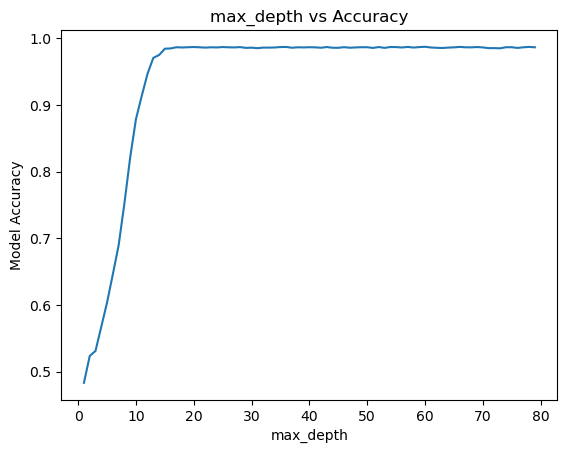

In [77]:
plt.plot(list(range(1,80)),acc_dict.values())
plt.xlabel("max_depth")
plt.ylabel("Model Accuracy")
plt.title("max_depth vs Accuracy")

In [78]:
dtree_clf=DecisionTreeClassifier(criterion='entropy', max_depth=25,min_samples_split=2, min_samples_leaf=1, 
                                 max_features=None,max_leaf_nodes=None) #initialising the classifier object with criterion as entropy,min_samples_split=2 and min_samples_leaf=1
fit=dtree_clf.fit(X_train,y_train)
y_pred=fit.predict(X_test)

In [79]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4286
           2       0.83      1.00      0.91         5
           3       0.99      1.00      0.99      1962
           4       0.98      0.98      0.98       520
           5       0.96      0.98      0.97      1095
           6       1.00      1.00      1.00       832
           7       0.99      0.97      0.98       267
           8       0.99      0.97      0.98       353
           9       0.94      0.95      0.94       522
          10       0.99      0.95      0.97       447
          11       0.97      0.99      0.98       103
          12       1.00      1.00      1.00        45

    accuracy                           0.99     10437
   macro avg       0.97      0.98      0.97     10437
weighted avg       0.99      0.99      0.99     10437



In [80]:
cm = confusion_matrix(y_test, y_pred) #passing the test set target values and the predicted values into the confusion matrix
cm

array([[4256,    1,    7,    8,    5,    0,    0,    1,    7,    1,    0,
           0],
       [   0,    5,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   1,    0, 1956,    1,    0,    0,    0,    0,    1,    3,    0,
           0],
       [   8,    0,    0,  508,    0,    0,    0,    0,    1,    0,    3,
           0],
       [   7,    0,    1,    0, 1070,    0,    1,    1,   14,    1,    0,
           0],
       [   0,    0,    0,    0,    0,  831,    0,    0,    1,    0,    0,
           0],
       [   0,    0,    0,    0,    2,    0,  259,    0,    6,    0,    0,
           0],
       [   0,    0,    0,    0,    9,    0,    0,  342,    2,    0,    0,
           0],
       [  10,    0,    0,    0,   12,    1,    2,    1,  496,    0,    0,
           0],
       [   0,    0,   11,    0,   11,    0,    0,    0,    0,  425,    0,
           0],
       [   0,    0,    0,    1,    0,    0,    0,    0,    0,    0,  102,
           0],
       [   0,    0,  

#### Feature Selection

In [81]:
from sklearn.utils import shuffle #importing shuffle package from sklearn library
new_idx = [] # initialzing an empty list for the new column indices
current_Max = 0.0 #setting the current maximum score as 0
col_no = 10 #setting the number of columns
col_idx_rd = shuffle(range(0,col_no), random_state=1) #shuffling the columns number
for cur_f in range(0, col_no): #iterating as many times as the number of columns
    new_idx.append(col_idx_rd[cur_f]) # Adding the current column index into list of column indices
    newX_train = X_train.iloc[:, new_idx] #creating a new train set with columns of the new index list
    newX_test=X_test.iloc[:, new_idx]  #creating a new train set with columns of the new index list
    dtree_clf=DecisionTreeClassifier(criterion='entropy', max_depth=25,min_samples_split=2, min_samples_leaf=1, 
                                 max_features=None,max_leaf_nodes=None) #initialising the classifier object
    fit = dtree_clf.fit(newX_train, y_train)  #fitting the classifier
    cur_Score = dtree_clf.score(newX_test, y_test)  #calculating the accuracy score with the current set of features
    if cur_Score < current_Max:  #if the current score is less than current maximum score, 
        new_idx.remove(col_idx_rd[cur_f]) #the indices of the features are removed from new index list
    else:
        current_Max= cur_Score #else current score is the maximum score
        print("Score with " + str(len(new_idx)) + " selected features: " + str(cur_Score))

Score with 1 selected features: 0.5656797930439782
Score with 2 selected features: 0.5678834914247389
Score with 3 selected features: 0.624221519593753
Score with 4 selected features: 0.7969723100507808
Score with 5 selected features: 0.9745137491616365
Score with 6 selected features: 0.995688416211555
Score with 7 selected features: 0.9987544313500047


In [82]:
new_idx #indices with the best accuracy

[2, 9, 6, 4, 0, 3, 1]

In [83]:
X_train=train_df.iloc[:,[2, 9, 6, 4, 0, 3, 1]] #choosing the features to obtain optimal result
X_test=test_df.iloc[:,[2, 9, 6, 4, 0, 3, 1]]

In [84]:
dtree_clf=DecisionTreeClassifier(criterion='entropy', max_depth=25,min_samples_split=2, min_samples_leaf=1, 
                                 max_features=None,max_leaf_nodes=None) #initialising the classifier object with criterion as entropy,min_samples_split=2 and min_samples_leaf=1
fit=dtree_clf.fit(X_train,y_train)
y_pred=fit.predict(X_test)

In [85]:
cm = confusion_matrix(y_test, y_pred) #passing the test set target values and the predicted values into the confusion matrix
cm

array([[4282,    0,    0,    2,    1,    0,    0,    1,    0,    0,    0,
           0],
       [   0,    5,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    0, 1962,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    0,    0,  518,    0,    0,    0,    0,    0,    0,    2,
           0],
       [   1,    0,    0,    0, 1094,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0,    0,  832,    0,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0,    0,    0,  267,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0,    0,    0,    0,  353,    0,    0,    0,
           0],
       [   0,    0,    0,    0,    0,    0,    4,    0,  518,    0,    0,
           0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  447,    0,
           0],
       [   0,    0,    0,    1,    0,    0,    0,    0,    0,    0,  102,
           0],
       [   0,    0,  

In [86]:
#printing classification report for updated model
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4286
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00      1962
           4       0.99      1.00      1.00       520
           5       1.00      1.00      1.00      1095
           6       1.00      1.00      1.00       832
           7       0.99      1.00      0.99       267
           8       1.00      1.00      1.00       353
           9       1.00      0.99      1.00       522
          10       1.00      1.00      1.00       447
          11       0.98      0.99      0.99       103
          12       1.00      1.00      1.00        45

    accuracy                           1.00     10437
   macro avg       1.00      1.00      1.00     10437
weighted avg       1.00      1.00      1.00     10437



It is evident that decision tree classifier is a better model suited to this than KNN classifier. Even without parameter tuning and feature selection, the decision tree was able to obtain good results. After feature selection, it managed to achieve near 100% precision and recall. This indicates that the features accurately help us distinguish between the copyists. 



Reference

Abhin Vijay (2024), Classifying Copyists of Manuscripts using K Nearest Neighbors and Decision Tree Classifier, Project Report